In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import numpy as np
import scipy.stats as ss
import scipy
import matplotlib.pyplot as plt
import requests

Импортирую данные с Яндекс.Диска с помощью API

In [118]:
def get_url(public_key): 
    base_url = 'https://cloud-api.yandex.net/v1/disk/public/resources/download?'
    final_url = base_url + urlencode(dict(public_key=public_key))
    response = requests.get(final_url) 
    download_url = response.json()['href'] 
    return download_url

In [119]:
groups = pd.read_csv(get_url('https://disk.yandex.ru/d/UhyYx41rTt3clQ'), sep=';')
group_add = pd.read_csv(get_url('https://disk.yandex.ru/d/5Kxrz02m3IBUwQ'), sep=',') 
active_studs = pd.read_csv(get_url('https://disk.yandex.ru/d/Tbs44Bm6H_FwFQ'), sep=';') 
checks = pd.read_csv(get_url('https://disk.yandex.ru/d/pH1q-VqcxXjsVA'), sep=';')

# Задание 1. A/B–тестирование

groups.csv - файл с информацией о принадлежности пользователя к контрольной или экспериментальной группе (А – контроль, B – целевая группа) 

group_add.csv - дополнительный файл с пользователями, который вам прислали спустя 2 дня после передачи данных

active_studs.csv - файл с информацией о пользователях, которые зашли на платформу в дни проведения эксперимента.

checks.csv - файл с информацией об оплатах пользователей в дни проведения эксперимента. 

In [120]:
groups.merge(group_add, how='inner', on='id') #повторяющихся id в этих фреймах нет, поэтому можем их просто склеить

,id,grp_x,grp_y


In [121]:
groups_new=pd.concat([groups, group_add], ignore_index=True) #объединяю данные groups с group_add, так как нам нужно видеть полную картину

In [122]:
groups.shape

(74484, 2)

In [123]:
group_add.shape

(92, 2)

In [124]:
groups_new.shape #проверяю, верно ли соединились данные

(74576, 2)

In [125]:
checks=checks.rename(columns={'student_id':'id'}) #меняю название столбца, чтобы объединить данные

In [126]:
groups_checks=groups_new.merge(checks, how='left', on='id') #добавляю данные о покупках

In [127]:
groups_checks['rev']=groups_checks['rev'].fillna(0) #заменяю отсутствующие значения на 0, так как это означает, что покупки не было

In [128]:
groups_checks=groups_checks.merge(active_studs, how='left', left_on='id', right_on='student_id')

In [129]:
groups_checks['student_id']=groups_checks['student_id'].fillna(0) #заменяю отсутствующие значения на 0, так как это означает, что пользователь не был активным 

In [130]:
active_users=groups_checks.query('student_id>0')

In [131]:
active_users

,id,grp,rev,student_id
1,1627,A,990.0,1627.0
10,2085,B,0.0,2085.0
12,2215,B,0.0,2215.0
43,3391,A,0.0,3391.0
45,3401,B,0.0,3401.0
...,...,...,...,...
74543,5760471,B,0.0,5760471.0
74545,5777081,B,0.0,5777081.0
74558,5870856,A,0.0,5870856.0
74561,5945085,B,0.0,5945085.0


In [132]:
groups_checks.groupby('grp', as_index=False).agg({'id':'count'}) #проверяю количество пользователей в контрольной и экспериментальной группах

,grp,id
0,A,14693
1,B,59883


In [133]:
groups_checks.query('rev>0 and student_id==0')

,id,grp,rev,student_id
39,3185,B,690.0,0.0
121,25973,B,690.0,0.0
125,26280,B,690.0,0.0
223,100645,B,630.0,0.0
254,102534,B,580.0,0.0
...,...,...,...,...
72452,5291900,B,199.0,0.0
72753,5331842,B,290.0,0.0
73632,5486319,B,199.0,0.0
74049,5562806,B,398.0,0.0


 Есть 149 пользователей, которые совершили покупку, но не были активны. Возможно, это баг системы, либо у пользователей подключены автоматические списания

# На какие метрики Вы смотрите в ходе анализа и почему?

ARPPU - Средний доход на платящего пользователя. ARPPU позволяет оценить влияние новой механики непосредственно на платящих клиентов. Думаю, это ключевая метрика бизнеса.

Конверсия в покупку. CR поможет определить, увеличилась ли конверсия в покупку благодаря новой механике оплаты.

In [134]:
AOV=active_users.groupby('grp', as_index=False).agg({'rev':'mean'})
AOV #посчитала средний чек

,grp,rev
0,A,47.347204
1,B,58.058798


In [135]:
#Считаю CR для контольной и экспериментальной групп
round((active_users.query('rev > 0').groupby('grp')
                                       .agg({'student_id': 'count'}) / active_users.groupby('grp') 
                                       .agg({'student_id': 'count'})) * 100, 2)

,student_id
grp,
A,5.07
B,4.62


In [136]:
ARPU=active_users.groupby('grp', as_index=False).agg({'rev':'mean'})
ARPU
#считаю средний доход с привлеченного пользователя

,grp,rev
0,A,47.347204
1,B,58.058798


In [137]:
active_and_pay_users=active_users.query('rev>0') #отбираю пользователей, которые были активны и совершали платежи

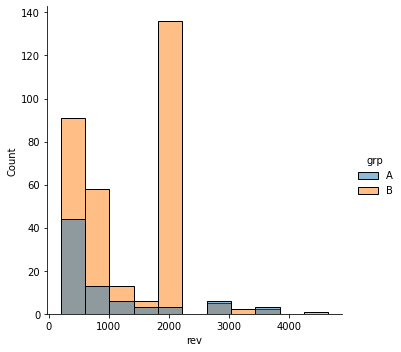

In [138]:
sns.displot(data=active_and_pay_users, x="rev", hue="grp") #смотрю их распределение

In [139]:
ARPPU=active_and_pay_users.groupby('grp', as_index=False).agg({'rev':'mean'})
ARPPU
#считаю средний доход на платящего пользователя

,grp,rev
0,A,933.589744
1,B,1257.878992


# Имеются ли различия в показателях и с чем они могут быть связаны?
Да, в интересующих нас метриках есть различия. ARPPU увеличилась в экспериментальной группе, CR уменьшилась.
Чтобы делать выводы, нужно проверить, являются ли эти различия статистически значимыми.

Чтобы определить, статистически ли значимо различие в метрике CR, использую критерий Хи-квадрат, так как наши переменные качественные и независимые

H0 - различий конверсии в покупку нет

H1 - различия конверсии в покупку есть

Создаю столбец is_pay, он понадобится нам для таблицы сопряженности

In [140]:
active_users['is_pay']=np.where(active_users.rev>0, 1, 0)

/opt/tljh/user/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [141]:
active_users

,id,grp,rev,student_id,is_pay
1,1627,A,990.0,1627.0,1
10,2085,B,0.0,2085.0,0
12,2215,B,0.0,2215.0,0
43,3391,A,0.0,3391.0,0
45,3401,B,0.0,3401.0,0
...,...,...,...,...,...
74543,5760471,B,0.0,5760471.0,0
74545,5777081,B,0.0,5777081.0,0
74558,5870856,A,0.0,5870856.0,0
74561,5945085,B,0.0,5945085.0,0


In [142]:
crosstab=pd.crosstab(active_users.grp, active_users.is_pay)
#создала таблицу сопряженности

In [143]:
crosstab

is_pay,0,1
grp,,
A,1460,78
B,6489,314


In [144]:
ss.chi2_contingency(crosstab)
# р-значение больше 0,05. У нас нет оснований отвергнуть нулевую гипотезу.

(0.48480826522557896,
 0.48625240457231045,
 1,
 array([[1465.71897854,   72.28102146],
        [6483.28102146,  319.71897854]]))

Критерий Хи-квадрат показал, что статистических различий конверсии в покупку нет.

Теперь проверю, является ли статистически значимой метрика ARPPU

In [145]:
control=active_and_pay_users.query('grp=="A"') #выделяю контрольную группу

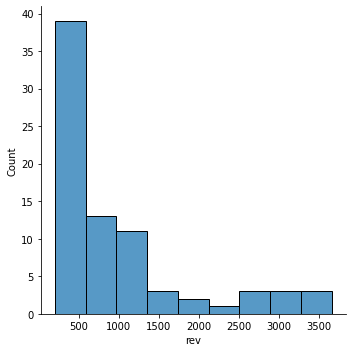

In [146]:
sns.displot(data=active_and_pay_users[active_and_pay_users.grp == 'A'], x="rev") #смотрю распределение

In [147]:
test=active_and_pay_users.query('grp=="B"') #выделяю экспериментальную группу

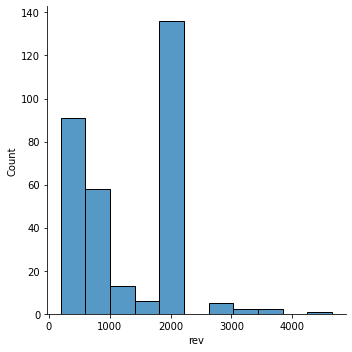

In [149]:
sns.displot(data=active_and_pay_users[active_and_pay_users.grp == 'B'], x="rev")#смотрю распределение

In [150]:
ss.shapiro(control.rev).pvalue #проверяю нормальность распределения в контрольной группе

1.4986822893803264e-10

In [151]:
ss.shapiro(test.rev).pvalue #проверяю нормальность распределения в экспериментальной группе

1.5437024585965894e-16

pvalue меньше 0,05. У нас есть основания отвергнуть нулевую гипотезу. Распределения в наших группах не являются нормальными

Так как t-тест при распределении, не являющемся нормальным, не стоит использовать, я бы хотела проверить наши данные с помощью bootstrap

In [152]:
active_and_pay_users.groupby('grp', as_index=False).agg({'rev': np.median}) #смотрю медианы в наших выборках

,grp,rev
0,A,585.0
1,B,1140.0


Внутри bootstrap посчитаю разницу между двумя группами по этому показателю и сохраню эти различия, тогда главным критерием будет, чтобы доверительный интервал не включал в себя 0.

In [153]:
control_df = active_and_pay_users[active_and_pay_users.grp == 'A'] #выделяю контрольную группу
test_df = active_and_pay_users[active_and_pay_users.grp == 'B'] #выделяю экспериментальную группу
median_diff = [] #создаю список, куда будет записываться разница

#пишу функцию для симуляции эксперимента 10 000 раз
for i in range(10000):
    sample_data_control = control_df.sample(frac=1, replace=True)
    sample_median_control = sample_data_control.rev.median()
    
    
    sample_data_test = test_df.sample(frac=1, replace=True)
    sample_median_test = sample_data_test.rev.median()
    
    sample_median_diff = sample_median_control - sample_median_test #считаю разницу медиан
    median_diff.append(sample_median_diff) #записываю разницу в созданный ранее список

In [154]:
pd.Series(median_diff).quantile(0.975)

-300.0

In [155]:
pd.Series(median_diff).quantile(0.025)

-1320.0

Как мы видим, доверительный интервал не включает в себя 0. 

Bootstrap показал, что различия в ARPPU являются статистически значимыми.

# Являются ли эти различия статистически значимыми?
Статистических различий конверсии в покупку (CR) нет.

Есть статистические различия метрики ARPPU.

# Вывод:
Мы не знаем, какая гипотеза проверялась A/B–тестированием.

Если целью было увеличить конверсию в покупку, то новую механику оплаты запускать не стоит, критерий Хи-квадрат показал, что нет статистически значимых различий между контрольной и экспериментальной группами.

Если же целью было увеличить средний доход на платящего пользователя, то новую механику стоит выкатить на всех пользователей, так как в экспериментальной группе данная метрика увеличилась.

# Задание 2. Python

Задаю переменную, в которой будет храниться ссылка на данные groups_add

In [156]:
group_new = 'https://disk.yandex.ru/d/5Kxrz02m3IBUwQ'

Создаю фкнкцию, которая будет автоматически подгружать информацию из дополнительного файла groups_add.

Функция автоматически пересчитывает интересные нам метрики.

# Задание 3. SQL

In [50]:
#импортирую библиотеку, чтобы подключиться к ClickHouse
import pandahouse as ph

In [51]:
# задаю параметры для подключения
connection_default = {'host': 'https://clickhouse.lab.karpov.courses',
                      'database':'default',
                      'user':'student', 
                      'password':'dpo_python_2020'
                     }

Необходимо написать оптимальный запрос, который даст информацию о количестве очень усердных студентов.

NB! Под усердным студентом мы понимаем студента, который правильно решил 20 задач за текущий месяц.

In [52]:
#пишу SQL запрос для решения данной задачи
diligent_students_query = """
SELECT COUNT(st_id) AS students
FROM (SELECT st_id, SUM(correct), toStartOfMonth(timest)
FROM default.peas
GROUP BY st_id, toStartOfMonth(timest)
HAVING SUM(correct)>19)
"""

In [53]:
diligent_students = ph.read_clickhouse(diligent_students_query, connection=connection_default)
diligent_students

,students
0,136


Необходимо в одном запросе выгрузить следующую информацию о группах пользователей:

ARPU 
ARPAU 
CR в покупку 
СR активного пользователя в покупку 
CR пользователя из активности по математике (subject = ’math’) в покупку курса по математике
ARPU считается относительно всех пользователей, попавших в группы.

Активным считается пользователь, за все время решивший больше 10 задач правильно в любых дисциплинах.

Активным по математике считается пользователь, за все время решивший 2 или больше задач правильно по математике.

In [54]:
funnel_optimization_query = """
WITH all_data AS (
  SELECT
    default.peas.st_id AS st_id,
    timest,
    correct,
    default.final_project_check.subject AS subject,
    test_grp,
    sale_time,
    money
  FROM
    default.studs
    LEFT JOIN default.final_project_check ON default.studs.st_id = default.final_project_check.st_id
    LEFT JOIN default.peas ON default.peas.st_id = default.studs.st_id)
    /*объединила таблицы и сохранила в переменную, на которую буду ссылаться далее*/





SELECT DISTINCT ARPU, ARPAU, CR, A_CR, CR_Math /*выбираю нужные нам метрики*/
FROM (SELECT 
        (SELECT Conversion/all_st AS CR /*считаю CR в покупку*/
FROM (SELECT
COUNT(st_id) FILTER (WHERE money>0) AS Conversion, /*делаю фильтрацию по пользователям, совершившим покупку*/
COUNT(st_id) AS all_st /*вычисляю количество всех пользователей*/
FROM all_data)) AS CR, 
        (SELECT SUM(A_Conversion)/SUM(all_st) AS A_CR /*считаю СR активного пользователя в покупку*/ 
FROM (SELECT SUM(correct), COUNT(st_id) AS all_st, COUNT(st_id) FILTER (WHERE money > 0) AS A_Conversion
FROM all_data
GROUP BY st_id /*группирую пользователей*/
HAVING SUM(correct)>10 )) AS A_CR, /*считаю тех, кто решил больше 10 задач*/
            (SELECT AVG(Conversion_Math / all_st) AS CR_Math /*CR пользователя из активности по математике в покупку курса*/
    FROM
      (SELECT
          COUNT(st_id) FILTER (WHERE money > 0) AS Conversion_Math,
          COUNT(st_id) AS all_st,
          SUM(correct)
        FROM all_data
        WHERE subject = 'Math' /*делаю фильтрацию по предмету=математике*/
        GROUP BY st_id
        HAVING SUM(correct) > 1) AS CR_Math ) AS CR_Math, /*Активным по математике считается пользователь, за все время решивший 2 или больше задач правильно по математике.*/
        (SELECT SUM(money)/COUNT(st_id) AS ARPU /*ARPU=(число клиентов/число всех пользователей)*(Доход/число клиентов). "Число клиентов" можно сократить*/
FROM all_data
) AS ARPU,
(SELECT SUMM/ st_id_pay AS ARPAU /*считаю доход деленный на число пользователей, которые совершали покупки*/
FROM 
 (SELECT COUNT(st_id) FILTER (WHERE money>0) AS st_id_pay, SUM(money) AS SUMM /*делаю фильтрацию по числу пользователей, которые совершали покупки*/
FROM all_data)) AS ARPAU
    FROM all_data)
"""

In [55]:
funnel_optimization = ph.read_clickhouse(funnel_optimization_query, connection=connection_default)
funnel_optimization

,ARPU,ARPAU,CR,A_CR,CR_Math
0,15143.360338,79703.374119,0.189996,0.204997,1.0


In [157]:
def group_add(group_new):

    def get_url(public_key):
        base_url = 'https://cloud-api.yandex.net/v1/disk/public/resources/download?' 
        final_url = base_url + urlencode(dict(public_key=public_key))
        response = requests.get(final_url) 
        download_url = response.json()['href'] 
        return download_url

    groups = pd.read_csv(get_url('https://disk.yandex.ru/d/UhyYx41rTt3clQ'), sep=';') 
    active_studs = pd.read_csv(get_url('https://disk.yandex.ru/d/Tbs44Bm6H_FwFQ'), sep=';') 
    checks = pd.read_csv(get_url('https://disk.yandex.ru/d/pH1q-VqcxXjsVA'), sep=';')
    groups_add_new=pd.read_csv(group_new)
    
    groups_add_new=pd.concat([groups, groups_add_new], ignore_index=True)
    checks=checks.rename(columns={'student_id':'id'}) 
    groups_add_checks=groups_add_new.merge(checks, how='left', on='id') 
    groups_add_checks['rev']=groups_add_checks['rev'].fillna(0) 
    groups_all=groups_add_checks.merge(active_studs, how='left', left_on='id', right_on='student_id')
    groups_all['student_id']=groups_all['student_id'].fillna(0)  

    for_metrics_ARPPU=groups_all.query('student_id>0 and rev>0')
    for_metrics_CR=groups_all.query('student_id>0')
    
    CR=round((for_metrics_CR.query('rev > 0').groupby('grp').agg({'student_id': 'count'}) / for_metrics_CR.groupby('grp') .agg({'student_id': 'count'})) * 100, 2)
    
    ARPPU=for_metrics_ARPPU.groupby('grp', as_index=False).agg({'rev':'mean'})
    ARPPU=ARPPU.rename(columns={'rev':'ARPPU'})
    metrics=CR.merge(ARPPU, on='grp')
    return(metrics)

data=group_add(group_new)
data

,grp,student_id,ARPPU
0,A,5.08,933.589744
1,B,4.61,1255.827487


Создаю функцию, которая будет строить графики по получаемым метрикам.

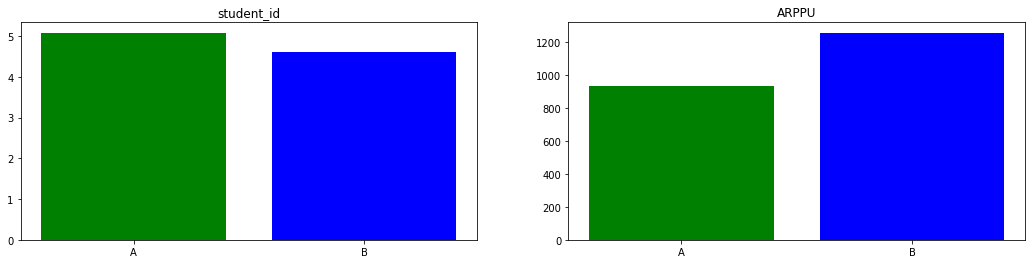

In [158]:
 def visualization(data):
    metrics = data.columns[1:] #подаю данные, записываю в переменную metrics
    
    fig, ax = plt.subplots(1, len(metrics), figsize=(18, 4)) #задаю условия
    for i in range(len(metrics)):
        ax[i].bar(x=data['grp'], height=data.iloc[:, i+1], color=['green', 'blue']) #использую функцию, которая рисует графики
        ax[i].set_title(data.iloc[:, i+1].name) #добавляю подписи
        
    plt.show() #вывожу графики
visualization(data)